Deep Convolutional Generative Adversarial Networks (ou DCGANs) são redes neurais compostas, não somente de um único modelo, mas de duas redes neurais que são treinadas simultaneamentes. Esse conceito de usar redes neurais em conjunto para desempenhar diferentes funções numa mesma tarefa, ou para treinar uma rede neural usando outra, é muito útil não só no campo da visão computacional e geração de imagens, como também deu enorme impulso a área de Aprendizado por Reforço nos últimos anos, permitindo que redes neurais consigam lidar com tarefas complexas, como passar de fases em jogos eletrônicos, até mesmo chegando ao ponto de vencer os melhores jogadores de Xadrez ou de Go do mundo.

Aqui, no entanto, vamos nos restringir ao uso de redes neurais adversárias em geração de imagens. Nas GANs, uma das redes (chamada de 'geradora') tem a função de aprender a criar imagens que pareçam reais, e a outra (a 'discriminadora') vai aprender a distinguir entre imagens reais e imagens geradas. É como se uma fosse um artista, tentando criar obras de arte, e a outra fosse um crítico de arte que busca diferenciar fotos obras reais de falsas.

O mais interessante das GANs é que, ao longo do treino, a geradora se torna cada vez melhor em criar imagens que pareçam verdadeiras, enquanto a discriminadora fica cada vez melhor em dizer qual é qual, e o processo atinge o equilíbrio quando a discriminadora não consegue mais separar as reais e as imagens criadas.

O objetivo aqui é exemplificar a construção e uso das DCGANs. Para isso, usaremos o MNIST dataset e mostraremos como, com o passar do treino, as imagens geradas pela geradora passam de aleatórias e amorfas para imagens cada vez mais parecidas com dígitos escritos a mão.

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import time
from IPython import display

In [6]:
# Carregando o MNIST dataset:
(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize images to [-1.0, +1.0]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-07-19 21:05:24.800147: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


O gerador usa camadas de convolução Conv2DTranspose, que vão produzir imagens a partir de imagens aleatórias sem forma definida. COmeçamos com uma camada Dense que usa essa imagem aleatória como input e então escalamos ela até o tamanho desejado (28x28x1):

In [7]:
def generator_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
        
    model.add(keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size.
    
    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

As linhas de "assert" são usadas apenas para termos certeza que uma afirmação significa exatamente aquilo que esperamos. Aqui, elas são camadas que checam se o formato do output é aquele esperado (None, 7, 7, 256), depois (None, 14, 14, 64), e por último (None, 28, 28, 1).

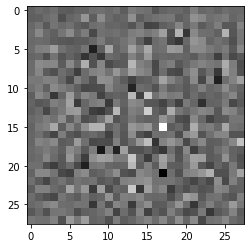

In [9]:
generator = generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Essa imagem acima é a imagem aleatória que o gerador, ainda sem treino, gera.

Agora, quanto ao discriminador, ele é uma Rede Neural Convolucional classificadora de imagens:

In [10]:
def discriminator_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=[28, 28, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))
    
    return model

Como dito anteriormente, usaremos o discriminador para classificar as imagens geradas pelo gerador. Ele será treinado para responder positivamente para imagens reais, e negativamente para imagens falsas:

In [11]:
discriminator = discriminator_model()
decision = discriminator(generated_image)

print(decision)

tf.Tensor([[0.00039028]], shape=(1, 1), dtype=float32)


Definiremos, então, a loss function e os otimizadores apropriados para o discriminador e o gerador: A função 'discriminator_loss' quantificará o quão bem o discriminador distriguirá as imagens reais e fakes, e a função 'generator_loss', o quão bem o gerador enganará o discriminador:

In [12]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Como precisaremos treinar os dois modelos separadamente, eles precisam também de otimizadores distintos:

In [15]:
gener_opt = keras.optimizers.Adam(1e-4)
discr_opt = keras.optimizers.Adam(1e-4)

Podemos usar checkpoints para salvar e restaurar os modelos, em caso do treino ser muito demorado:

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=gener_opt,
                                 discriminator_optimizer=discr_opt,
                                 generator=generator,
                                 discriminator=discriminator)

Agora definiremos o loop de treino, que começará com o gerador recebendo o input aleatório para gerar uma imagem. Então, o discriminador classificará imagens trazidas do training set, as reais, e produzidas pelo gerador, as falsas. Por fim, o loss é calculado para cada um desses modelos, e os gradientes são usados para atualizar o gerador e o discriminador com o passar dos loops:

In [29]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [30]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
    gener_opt.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discr_opt.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [31]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produzir imagens para os GIFs ao longo do treino:
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Salvar o modelo a cada 15 segundos:
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch:
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [32]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('Image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

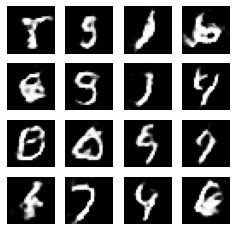

In [33]:
train(train_dataset, EPOCHS)

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Podemos exibir uma imagem de cada vez usando o número da época a qual ela pertence:

In [35]:
def display_image(epoch_no):
    return PIL.Image.open('Image_at_epoch_{:04d}.png'.format(epoch_no))

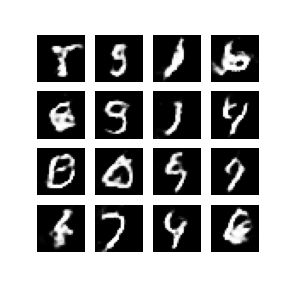

In [36]:
display_image(EPOCHS)

Agora, criamos um gif animado usando todas as imagens que foram geradas e salvas pra cada época:

In [37]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Após duzentas épocas, o gif resultante de todas as imagens geradas é o seguinte:

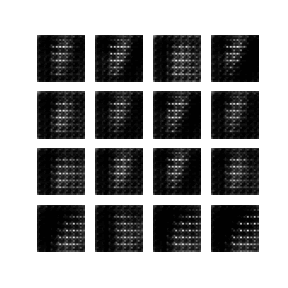

In [38]:
from IPython.display import Image

Image(filename="dcgan_200.gif")

Percebemos como as primeiras imagens eram aleatórias e sem forma definida, e com o passar do tempo o gerador ficou tão bom em gerar imagens parecidas com as do MNIST dataset que elas ficaram indistinguíveis das imagens reais do MNIST, e o discriminador e o gerador entraram em equilíbrio (o que é evidenciado ao perceber que as imagens finais estabilizaram em formas parecidas com as de números definidos).